# Bayesian Quantum Noise Spectroscopy

[Chris Ferrie](https://csferrie.com/), [Chris Granade](http://www.cgranade.com/), [Gerardo Paz-Silva](https://www.griffith.edu.au/science-aviation/centre-quantum-dynamics/staff-students/staff/gerardo-paz-silva), [Howard Wiseman](http://www.ict.griffith.edu.au/wiseman/)

This is supplementary material supplied with the paper of the same name.

## Preamble

First, we turn on the ``division`` feature, as is recommended for using Python 2.x with scientific code.

In [1]:
from __future__ import division

Next, we enable plotting support, using ``inline`` to make all of the plots load inside the notebook.

In [2]:
%matplotlib inline

We'll want to set some sensible defaults for matplotlib, too.

In [3]:
import matplotlib.pyplot as plt
try:
    plt.style.use('ggplot-rq')
except:
    plt.style.use('ggplot')
import matplotlib as mpl
import matplotlib.ticker as ticker

We'll need a few more imports:

In [4]:
import numpy as np # standard numerical package
import scipy.stats as st # statistical functions
import scipy.linalg as la # linear algebra for matrix functions
from scipy.interpolate import interp1d
from scipy import optimize # used to learn kernels
from filters import * # this contains refactored modules for this research
from plot_utils import * # to make plotting code cleaner

Finally, we'll try to import QInfer, and will mark it as not imported if it's not available.

In [5]:
try:
    import qinfer as qi
except:
    qi = None

## Model and data fitting

We define a new function to calculate $F(\omega)$, the filter function, given by the Fourier transform of an alternating $\pm 1$ function $y(t)$. To do so, we provide a specification of the times $\{t_k\}$ at which the value of $y(t)$ changes, including the endpoints of the control sequence $t_0 = 0$ and $t_N = T$.

Following previous conventions, we will curry this definition over $\omega$, such that we can change which points we evaluate $F$ at dynamically.

In [6]:
def flatten_2d(list_2d):
    return sum(map(list, list_2d), [])

In [7]:
T = 1 # final time

n_seq = 25 # number of sequences or filters

res_omega = 100 # resolution in omega
Omega = np.pi / T * n_seq # upper bound on integral (high frequency cutoff)

omega = np.linspace(1e-10, Omega,res_omega)

filter_funs = []

for idx in range(n_seq):
    seq = np.arange(0,T * 1.00001, T / (idx + 1))
    filter_funs.append(generic_filter(seq))

Plot them:

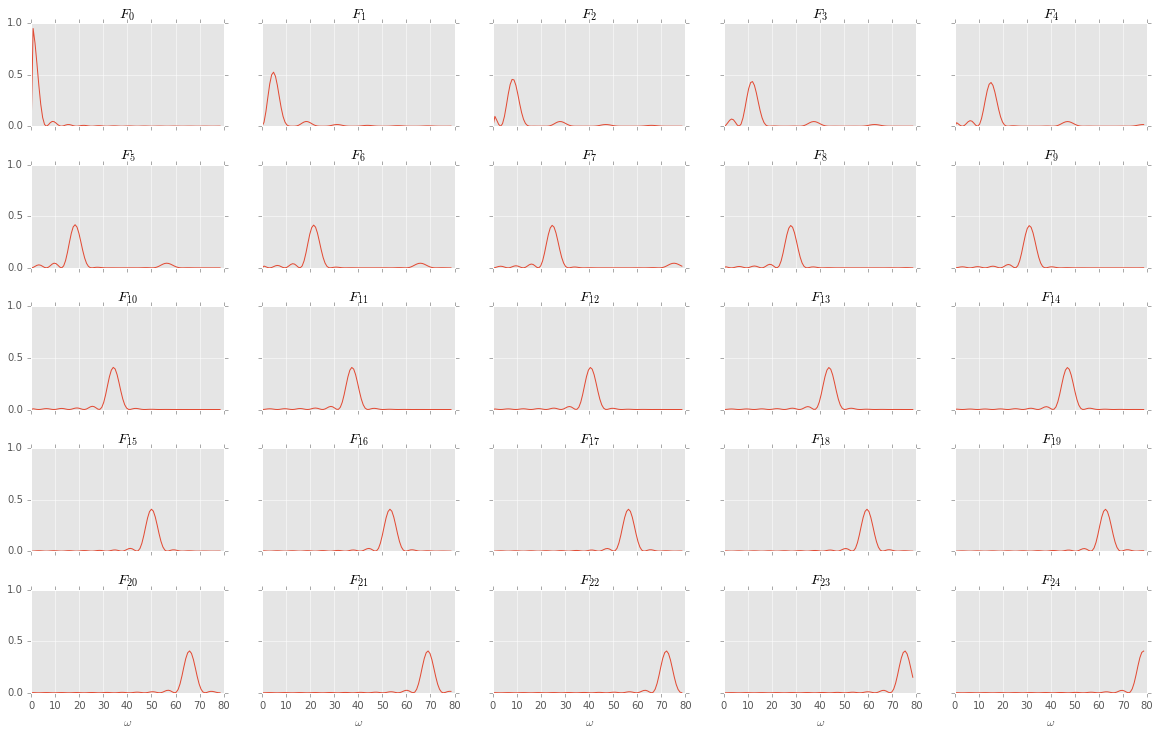

In [8]:
box = int(np.ceil(np.sqrt(n_seq)))
fig, axes = plt.subplots(box, box, figsize=(20, 12), sharex=True, sharey=True, gridspec_kw={'hspace': 0.375})

for idx, (filter_fn, ax) in enumerate(zip(filter_funs, flatten_2d(axes))):
    plt.sca(ax)
    plt.plot(omega, filter_fn(omega))
    plt.title('$F_{{{}}}$'.format(idx))
    plt.ylim(0, 1)
    plt.yticks([0, 0.5, 1])

for ax in axes[-1][:]:
    plt.sca(ax)
    plt.xlabel(r'$\omega$')
    
paper_figure('filter-fns')

We will simulate performing measurements using these filters. The following functions will be helpful to create data sets.

In [9]:
def est_chi(counts, n_shots, hedge=0.0):
    # Takes the number of successes (counts) and number
    # of measurments (n_shots) and returns chi
    
    return -np.log(2 * (
        (counts + hedge) / (n_shots + 2 * hedge)
    ) - 1)

def sample_data_record(true_spec, filters, n_shots, omega):
    # simulates a data record from a true spectrum and n_shots experiments
    # performed using the sequences defined in filters
    # calculation of probabilities (via the integral in the paper) are
    # done using the trapezoid rule at the values in omega
    chi = np.array([
        trapz_ip(omega)(filter_fn, true_spec)[0]
        for filter_fn in filters
    ]) / (2 * np.pi)
    counts = np.random.binomial(n_shots, 0.5 * (1 + np.exp(-chi)))
    chi_hat = est_chi(counts, n_shots, 1e-10)
    hedged_chi_hat = est_chi(counts, n_shots, 0.509)
    
    std_errors = np.sqrt((np.exp(2 * chi_hat) - 1) / n_shots)
    
    expparams = np.empty((len(filters), ), dtype=[('filter_fns', object), ('n_meas', 'uint')])
    expparams['filter_fns'] = filters
    expparams['n_meas'] = n_shots
    
    return {
        'chi': chi,
        'chi_hat': chi_hat,
        'hedged_chi_hat': hedged_chi_hat,
        'counts': counts,
        'std_errors': std_errors,
        'expparams': expparams
    }

In forming our "naive" spectral density estimates, we will require the normalizations $f_k \mathrel{:=} \int \mathrm{d}\omega F_k(\omega)$ and the maxima $\omega_k \mathrel{:=} \operatorname*{arg\,max}_{\omega} F_k(\omega)$. We calculate these below for later convienence.

In [10]:
filter_normalizations = np.array([
    np.trapz(filter_fn(omega), x=omega)
    for filter_fn in filter_funs
])
filter_maxima = np.array([
    omega[np.argmax(filter_fn(omega))]
    for filter_fn in filter_funs
])

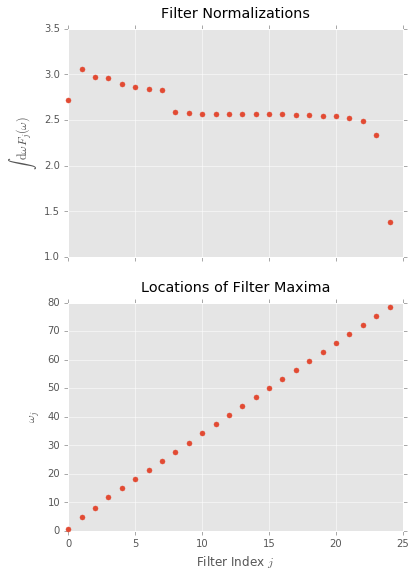

In [11]:
fig, (top, bottom) = plt.subplots(nrows=2, ncols=1, figsize=(6, 9), sharex=True)

top.plot(filter_normalizations, '.', clip_on=False, zorder=100, markersize=10)
top.set_ylabel(r'$\int\ \mathrm{d}\omega F_j(\omega)$')
title = top.set_title('Filter Normalizations')
title.set_position([0.5, 1.025])

bottom.plot(filter_maxima, '.', clip_on=False, zorder=100, markersize=10)
bottom.set_xlabel('Filter Index $j$')
bottom.set_ylabel(r'$\omega_j$')
title = bottom.set_title('Locations of Filter Maxima')
title.set_position([0.5, 1.025])

paper_figure('filter-naive-props')

We can now define the "naive" estimate $\hat{S}_{\text{naive}}(\omega_j) = 2 \pi \hat{\chi}_j / f_j$.

In [12]:
def naive_est(chi_hats, filter_normalizations, filter_maxima):
    return interp1d(
        x=filter_maxima,
        y=2 * np.pi * chi_hats / filter_normalizations,
        fill_value="extrapolate"
    )

## Gaussian Process regression

The prior distribution of $S(\omega)$ will be a Gaussian Process, which means that the distribution (conditional or not) of $\{S(\omega_j)\}$ is Normal.  The covariance matrix is specified by a kernel, the most common of which is the squared exponential
$$
k(\omega_i,\omega_j) = \exp[-(\omega_i-\omega_j)^2/\delta],
$$
where $\delta$ controls the correlation length.

In [13]:
def sq_exp_ker(omega, uncert=1, corr=1):    
    cov = uncert * np.exp(-(omega - omega[:, None]) ** 2 / corr)
    
    # Add to this a regularizing term for stability
    return cov + 1e-10 * np.eye(omega.shape[0])

def mean_fun(omega, omega_prime, width, heigth):
    return np.exp(-(omega - omega_prime) ** 2 / width) * height

interpolation_ws = np.linspace(1e-10, Omega, int(1000))
def sample(omega_prime, width, height, uncert, corr, prior_mean=None, interpolation_ws=interpolation_ws):
    
    if prior_mean == None:
        prior_mean = mean_fun(interpolation_ws, omega_prime, width, height)
    prior_cov = sq_exp_ker(interpolation_ws, uncert, corr)
    Phi = np.real(la.sqrtm(prior_cov))
    ys = np.dot(Phi, np.random.randn(interpolation_ws.shape[0])) + prior_mean

    return interp1d(interpolation_ws, ys[np.newaxis], axis=-1)

Now let's consider an example Gaussian Process. To visualize it, we will plot the mean function, a single sample from the process and 95% credible band.

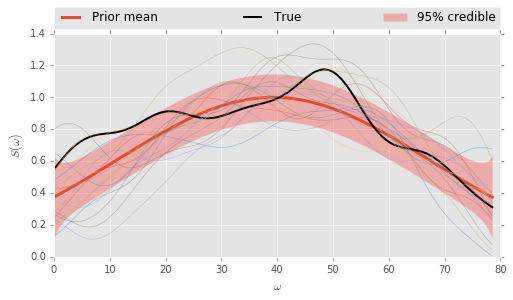

In [14]:
# mean function params
omega_prime = Omega / 2
width = 20 * Omega
height = 1e-0

# kernel params
uncert = 2e-2
corr = 1e2

prior_mean = mean_fun(omega, omega_prime, width, height)
prior_cov  = sq_exp_ker(omega, uncert, corr)

plt.figure(figsize=(8,4))

plt.plot(omega,prior_mean, linewidth = 3, label = 'Prior mean')

Phi = np.real(la.sqrtm(prior_cov))

z = st.norm.ppf(1-.025/res_omega)

up = prior_mean + z*np.diag(Phi)
down = prior_mean - z*np.diag(Phi)

plt.fill_between(omega, up, down, facecolor='r', alpha=0.25, label = '95% credible')

true_spec = sample(omega_prime, width, height, uncert, corr )


plt.plot(omega,true_spec(omega)[0], 'k', linewidth=2, label='True')
for idx_sample in range(20):
    foo = sample(omega_prime, width, height, uncert, corr)
    plt.plot(omega, foo(omega)[0], linewidth=0.5, alpha=0.6)

top_legend(ncol=3)
plt.xlabel('$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.ylim(0);

paper_figure('example-prior')

Let's take that sample above as the "true" spectrum of the system and simulate performing repeated measurements usings each of the filters defined above.

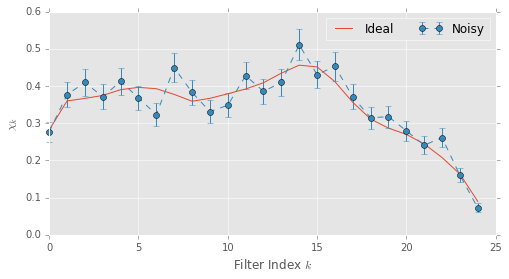

In [15]:
plt.figure(figsize=(8,4))

n_shots = 1000
data_record = sample_data_record(true_spec, filter_funs, n_shots, omega)
plt.plot(data_record['chi'], label='Ideal')

e = plt.errorbar(
    np.arange(n_seq),
    data_record['chi_hat'], data_record['std_errors'],
    fmt='--o', label='Noisy', clip_on=False
)
for b in e[1]:
    b.set_clip_on(False)

plt.xlabel('Filter Index $k$')
plt.ylabel(r'$\chi_k$')
plt.legend(ncol=2);

paper_figure('example-naive-data')

Now, take that data and plot the true spectrum again along with the naive estimator. We will do so with both the simulated data and ideal (noiseless) data. The latter will show the unavoidable error in making the delta approximation to the filter functions.

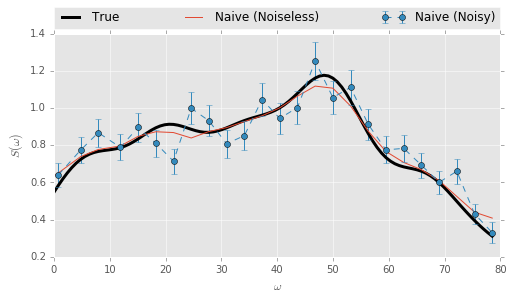

In [16]:
plt.figure(figsize=(8,4))

plt.plot(omega,true_spec(omega)[0], 'k', linewidth=3, label='True')
plt.plot(omega, naive_est(data_record['chi'], filter_normalizations, filter_maxima)(omega), label=u"Naive (Noiseless)")

e = plt.errorbar(
    filter_maxima,
    naive_est(data_record['chi_hat'], filter_normalizations, filter_maxima)(filter_maxima),
    naive_est(data_record['std_errors'], filter_normalizations, filter_maxima)(filter_maxima),
    fmt='--o', label=u"Naive (Noisy)", clip_on=False
)
for b in e[1]:
    b.set_clip_on(False)
    
plt.xlabel(r'$\omega$')
plt.ylabel(r'$S(\omega)$')
top_legend();

paper_figure('example-naive-bias')

Notably, that the noiseless and the true do not coincide shows that this estimation procedure is *biased*; that's not necessarily a problem, especially as the bias is relatively small, but demonstrates that we can possibly do better.

We can update the prior Gaussian Process to a posterior one with Bayes rule.

In [17]:
def bayes_update(chi_hats, n_shots, prior_mean, prior_cov, omega, res_omega, omega_max):
    like_cov = np.eye(n_seq) * (np.exp(2 * chi_hats) - 1) / n_shots
    
    kernel_mtx = np.zeros((n_seq, res_omega))
    for idx, filter_fn in enumerate(filter_funs):
        kernel_mtx[idx] = filter_fn(omega)
    kernel_mtx *= omega_max / (2 * res_omega * np.pi)
    kernel_mtx[:, [0, -1]] /= 2
    
    like_inv = la.inv(like_cov)
    prior_inv = la.inv(prior_cov)
    
    X = np.linalg.multi_dot([kernel_mtx.T, like_inv, kernel_mtx]) + prior_inv
    y = np.linalg.multi_dot([chi_hats, like_inv, kernel_mtx]) + np.dot(prior_mean.T, prior_inv)
    
    post_cov = la.inv(X)
    post_mean = np.dot(post_cov, y)    
    
    interp_est = interp1d(y=post_mean, x=omega)
    
    return interp_est, post_mean, post_cov

In [18]:
_, post_mean, post_cov = bayes_update(data_record['chi_hat'], n_shots, prior_mean, prior_cov, omega, res_omega, Omega)

Finally, we plot the posterior mean function and credible band along with the naive estimator.

In [19]:
def plot_bayes_gp(data_record, post_mean, post_cov, show_credible=True):
    fig = plt.figure(figsize=(10, 4))

    ax = plt.gca()

    #plt.plot(omega,prior_mean,'k.', label = 'Prior mean')

    Phi = np.real(la.sqrtm(post_cov))

    plt.plot(omega,post_mean, linewidth = 3, label = 'Posterior mean')

    plt.plot(omega, true_spec(omega)[0], 'k', linewidth = 3, label='True')

    if show_credible:
        up = post_mean + z*np.diag(Phi)
        down = post_mean - z*np.diag(Phi)

        plt.fill_between(omega, up, down, facecolor='r', alpha=0.25, label='95% credible')

    plt.plot(omega, naive_est(data_record['chi_hat'], filter_normalizations, filter_maxima)(omega), label=u"Naive", )

    top_legend(ncol=4)
    plt.xlabel('$\omega$');
    plt.ylabel(r'$S(\omega)$')

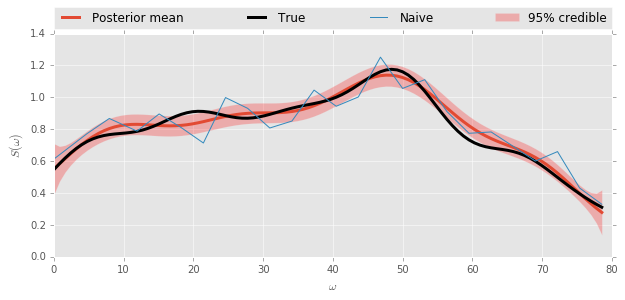

In [20]:
plot_bayes_gp(data_record, post_mean, post_cov)
paper_figure('example-gp-est')

Comparing to the same with less shots demonstrates the utility of the error bars provided by the credible region.

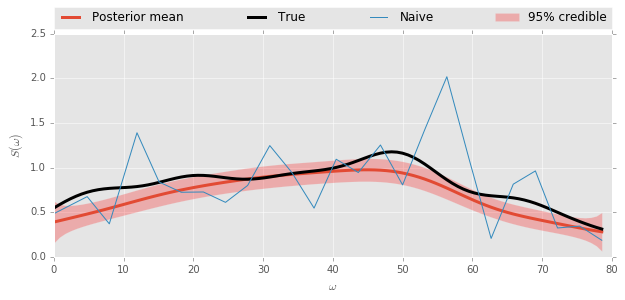

In [21]:
n_shots = 50

data_record = sample_data_record(true_spec, filter_funs, n_shots, omega)
_, post_mean, post_cov = bayes_update(data_record['chi_hat'], n_shots, prior_mean, prior_cov, omega, res_omega, Omega)

plot_bayes_gp(data_record, post_mean, post_cov)
paper_figure('example-gp-est-low-shots')

## Loss

Here we define the loss function which takes the discrepancy above and averages it to a single number so that we can consolidate many random trials. We use the standard mean squared error.

In [22]:
class mean_sq_err(object):
    def __init__(self, omegas):
        self._ws = omegas
        
    def __call__(self, true_spec_fn, est_spec_fn):
        true_spec = true_spec_fn(self._ws)
        est_spec = est_spec_fn(self._ws)
        
        return np.trapz(np.abs(true_spec - est_spec) ** 2, x=self._ws)

In [23]:
def perf_test_specdens_est(
        n_trials,
        n_shots,
        omega,
        omega_max
):
    loss_fn = mean_sq_err(omega)
    
    progbar = qi.IPythonProgressBar() if qi else None
    if progbar:
        progbar.start(n_trials)
    losses = {
        est_name: np.zeros(n_trials)
        for est_name in ('prior', 'post', 'naive')
    }

    for idx_trial in range(n_trials):
        true_spec = sample(omega_prime, width, height, uncert, corr)
        data_record = sample_data_record(true_spec, filters=filter_funs, n_shots=n_shots, omega=omega)
        
        post_est, post_mean, post_cov = bayes_update(
            data_record['chi_hat'], n_shots, prior_mean, prior_cov,
            omega, len(omega), omega_max
        )
        for est_name, est in {
            'post': post_est,
            'prior': interp1d(y=prior_mean, x=omega),
            'naive': naive_est(data_record['chi_hat'], filter_normalizations, filter_maxima)
        }.items():
            losses[est_name][idx_trial] = loss_fn(true_spec, est)
        if progbar:
            progbar.update(idx_trial + 1)
        
    if progbar:
        progbar.finished()
    return losses

In [25]:
%%time
losses_100 = perf_test_specdens_est(400, 100, omega, Omega)

Wall time: 8min 10s


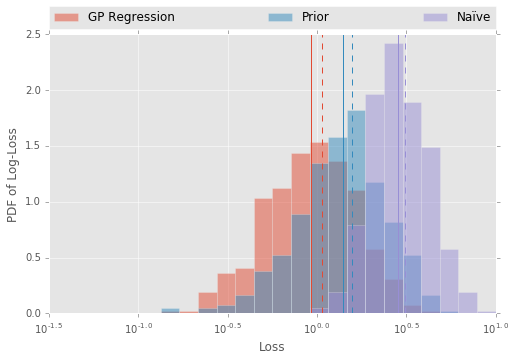

In [26]:
plot_losses(losses_100, plt_range=(-1.5, 1))
top_legend()
paper_figure('gp-loss-hist_N-100')

In [27]:
%%time
losses_1000 = perf_test_specdens_est(400, 1000, omega, Omega)

Wall time: 8min 10s


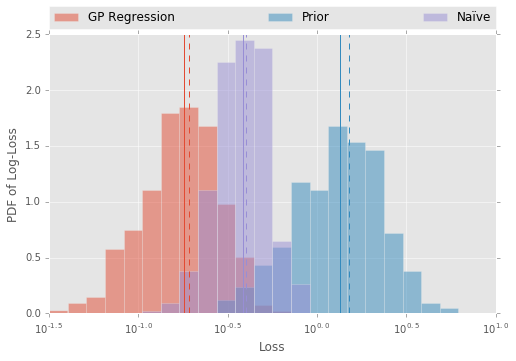

In [28]:
plot_losses(losses_1000, plt_range=(-1.5, 1))
top_legend()
paper_figure('gp-loss-hist_N-1000')

## Hyperparameter learning

Here we will consider the $1/f$ noise model as described in the paper. We will use use [Qinfer](https://qinfer.org) for the numerical integration in the Bayesian updates. 

In [57]:
spectral_model = lambda alpha, A, omega_cut: one_on_f(alpha=alpha, A=A, cut=omega_cut)
spectral_prior = qi.ProductDistribution(
    # Distribution over α.
    qi.UniformDistribution([0.5, 1]),
    # Distribution over A.
    qi.NormalDistribution(10, 0.5 ** 2),
    # Distribution over ω_ir.
    ExponentialDistribution(minimum=3, scale=0.1)
)

We now need to worry about whether we take a mean on the spectra or the hyperparams.

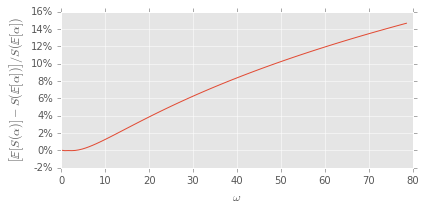

In [58]:
plt.figure(figsize=(6, 3))

spectra_then_mean = np.mean(spectral_model(*spectral_prior.sample(n=10000).T)(omega), axis=0)
mean_then_spectra = spectral_model(*np.mean(spectral_prior.sample(n=10000), axis=0).T)(omega)

plt.plot(omega, (spectra_then_mean - mean_then_spectra) / mean_then_spectra)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\left[\mathbb{E}[S(\alpha)] - S(\mathbb{E}[\alpha]) \right] / S(\mathbb{E}[\alpha])$')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))

plt.tight_layout()
paper_figure('mean-then-spectra')

The error incurred by this difference is actually quite substantial, even though it appears insignificant
in the plot above.

In [59]:
np.trapz(np.abs(spectra_then_mean - mean_then_spectra) ** 2, x=omega)

0.12511210493500835

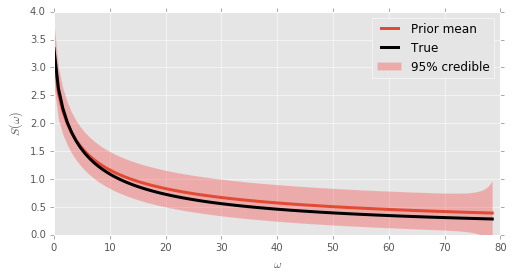

In [62]:
true_spec = spectral_model(*spectral_prior.sample().T)

prior_mean = spectra_then_mean
corr = 1e2
uncert = 1e-1
prior_cov  = sq_exp_ker(omega, uncert, corr)

plt.figure(figsize=(8, 4))

plt.plot(omega,prior_mean, linewidth = 3, label = 'Prior mean')

Phi = np.real(la.sqrtm(prior_cov))

z = st.norm.ppf(1-.025/res_omega)

up = prior_mean + z*np.diag(Phi)
down = prior_mean - z*np.diag(Phi)

plt.fill_between(omega, up, down, facecolor='r', alpha=0.25, label = '95% credible')

plt.plot(omega,true_spec(omega)[0],'k', linewidth = 3, label = 'True')

plt.legend(loc='upper right')
plt.xlabel('$\omega$')
plt.ylabel(r'$S(\omega)$')
plt.ylim(0);

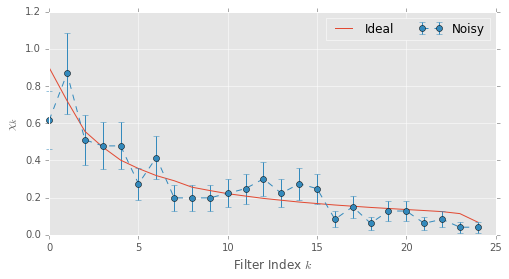

In [63]:
plt.figure(figsize=(8,4))

n_shots = 100
data_record = sample_data_record(true_spec, filter_funs, n_shots, omega)
plt.plot(data_record['chi'], label='Ideal')

e = plt.errorbar(
    np.arange(n_seq),
    data_record['chi_hat'], data_record['std_errors'],
    fmt='--o', label='Noisy', clip_on=False
)
for b in e[1]:
    b.set_clip_on(False)

plt.xlabel('Filter Index $k$')
plt.ylabel(r'$\chi_k$')
plt.legend(ncol=2);

In [64]:
post_est, post_mean, post_cov = bayes_update(data_record['chi_hat'], n_shots, prior_mean, prior_cov, omega, res_omega, Omega)
updater = qi.SMCUpdater(
    qi.BinomialModel(HyperparameterizedSpectralModel(spectral_model, omega)),
    10000,
    spectral_prior
)
for experiment, datum in zip(data_record['expparams'][..., None], data_record['counts']):
    updater.update(datum, experiment)

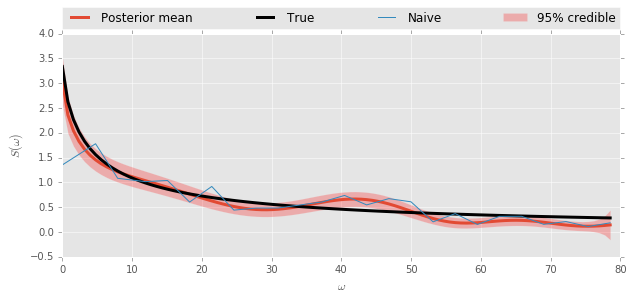

In [65]:
plot_bayes_gp(data_record, post_mean, post_cov, show_credible=True)
paper_figure('example-gp-est-one-on-f')

In [66]:
def perf_test_specdens_est_hyper(
        n_trials,
        n_shots,
        omega,
        omega_max,
        spectral_model, prior, n_particles=6000
):
    model = qi.BinomialModel(HyperparameterizedSpectralModel(spectral_model, omega))
    
    
    loss_fn = mean_sq_err(omega)
    
    progbar = qi.IPythonProgressBar() if qi else None
    if progbar:
        progbar.start(n_trials)
    est_names = ('prior', 'post', 'naive', 'hyper_stm', 'hyper_mts')
    spec_losses = {
        est_name: np.zeros(n_trials)
        for est_name in est_names
    }
    alpha_losses = []
    residuals = {
        est_name: []
        for est_name in est_names
    }

    for idx_trial in range(n_trials):
        true_params = prior.sample()
        true_spec = spectral_model(*true_params.T)
        data_record = sample_data_record(true_spec, filters=filter_funs, n_shots=n_shots, omega=omega)
        
        # GP Est
        post_est, post_mean, post_cov = bayes_update(
            data_record['chi_hat'], n_shots, prior_mean, prior_cov,
            omega, len(omega), omega_max
        )
        
        # Hyperparam est
        updater = qi.SMCUpdater(model, n_particles, prior)
        for experiment, datum in zip(data_record['expparams'][:, None], data_record['counts']):
            updater.update(datum, experiment)
            
        hyper_est = updater.model.underlying_model.hyperparameterized_est(updater)
                
        alpha_losses.append(np.sum(np.abs(
            true_params[..., 0] - updater.est_mean()[..., 0]
        ) ** 2))
        
        for est_name, est in {
            'post': post_est,
            'prior': interp1d(y=prior_mean, x=omega),
            'naive': naive_est(data_record['chi_hat'], filter_normalizations, filter_maxima),
            'hyper_stm': hyper_est,
            'hyper_mts': spectral_model(*updater.est_mean())
        }.items():
            spec_losses[est_name][idx_trial] = loss_fn(true_spec, est)
            residuals[est_name].append((true_spec(omega) - est(omega))[0, :])
            
        if progbar:
            progbar.update(idx_trial + 1)
        
    if progbar:
        progbar.finished()
    return spec_losses, alpha_losses, residuals

In [74]:
%%time
spec_losses, alpha_losses, spec_residuals = perf_test_specdens_est_hyper(
    400, 100, omega, Omega,
    spectral_model, spectral_prior,
    n_particles=1000
)

Wall time: 1min 18s


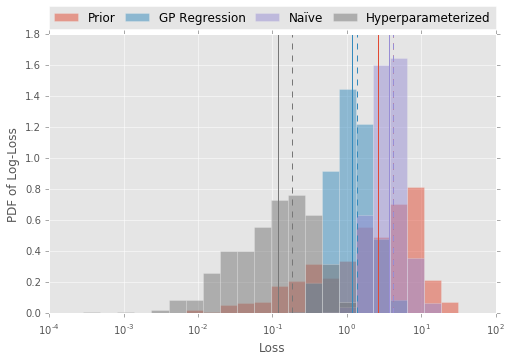

In [75]:
plot_losses(spec_losses, est_names=('prior', 'post', 'naive', 'hyper_stm'), plt_range=(-4, 1.5), plt_step=1, log_digits=0)
top_legend(ncol=4);

paper_figure('one-on-f-loss-hist_N-100')

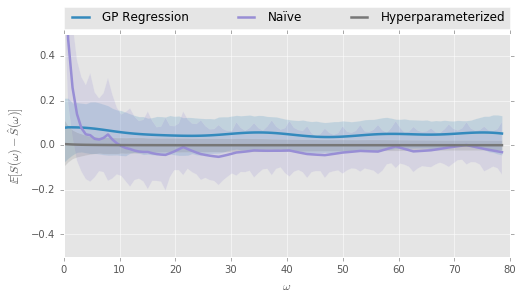

In [76]:
plt.figure(figsize=(8, 4))
# Skip the prior.
skip_prop_cycle()
for est_name in ('post', 'naive', 'hyper_stm'):
    mean_residual = np.mean(spec_residuals[est_name], axis=0)
    down, up = [np.percentile(spec_residuals[est_name], q=q, axis=0) for q in (25, 75)]
    line, = plt.plot(omega, np.mean(spec_residuals[est_name], axis=0),
                     label=est_descripts[est_name].replace('Loss', 'Bias'), lw=2.5)
    plt.fill_between(omega, up, down, alpha=0.2, facecolor=line.get_color())

plt.ylim(-0.5, 0.5)
top_legend(ncol=3)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\mathbb{E}[S(\omega) - \hat{S}(\omega)]$')
paper_figure('one-on-f-residuals')

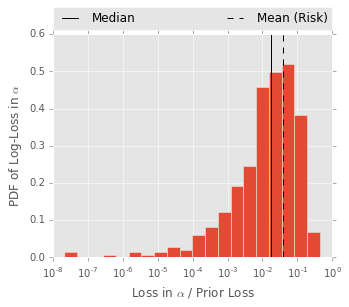

In [77]:
plt.figure(figsize=(5, 4))

normed_losses = alpha_losses / np.var(spectral_prior.sample(n=1000)[:, 0])
plt.hist(np.log10(normed_losses), normed=True, bins=20)
plt.xlabel(r'Loss in $\alpha$ / Prior Loss')

ylim = plt.ylim()
plt.vlines(np.median(np.log10(normed_losses)), label='Median', *ylim)
plt.vlines(np.log10(np.mean(normed_losses)), label='Mean (Risk)', linestyle='--', *ylim)
plt.ylim(*ylim)

top_legend(ncol=2, loc='upper center')
plt.gca().get_xaxis().set_major_formatter(log_formatter(0))
plt.ylabel(r'PDF of Log-Loss in $\alpha$')

paper_figure('hyperparameter-loss-hist')

In [71]:
%%time
spec_losses, alpha_losses, spec_residuals = perf_test_specdens_est_hyper(
    400, 1000, omega, Omega,
    spectral_model, spectral_prior,
    n_particles=1000
)

C:\Users\csfer\Anaconda3\lib\site-packages\qinfer-1.0-py3.5.egg\qinfer\smc.py:285: ApproximationWarning: Extremely small n_ess encountered (8.122720498253155). Resampling is likely to fail. Consider adding particles, or resampling more often.


Wall time: 1min 19s


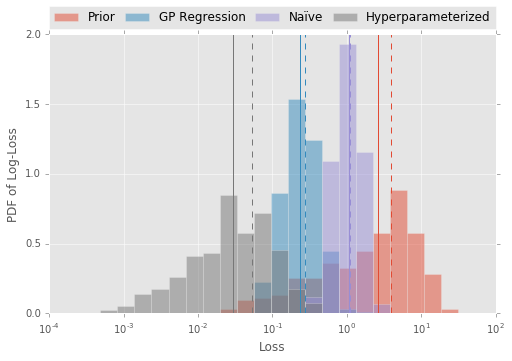

In [72]:
plot_losses(spec_losses, est_names=('prior', 'post', 'naive', 'hyper_stm'), plt_range=(-4, 1.5), plt_step=1, log_digits=0)
top_legend(ncol=4);

paper_figure('one-on-f-loss-hist_N-1000')